In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
with open("/kaggle/input/flickr8k/captions.txt", "r") as f:
    for i in range(10):
        print(repr(f.readline()))


'image,caption\n'
'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n'
'1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n'
'1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n'
'1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n'
'1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n'
'1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n'
'1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n'
'1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n'
'1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n'


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

CAP_FILE = "/kaggle/input/flickr8k/captions.txt"
IMG_FOLDER = "/kaggle/input/flickr8k/Images"

image_captions = {}

# Parse CSV captions file
with open(CAP_FILE, 'r') as f:
    next(f)  # skip header
    for line in f:
        line = line.strip().strip('"')
        if not line or ',' not in line:
            continue
        img_id, caption = line.split(',', 1)
        if img_id not in image_captions:
            image_captions[img_id] = []
        image_captions[img_id].append(caption)

print("Total images with captions:", len(image_captions))


Total images with captions: 8091


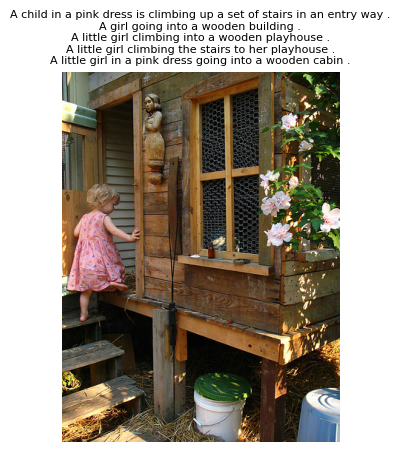

In [3]:
sample_img_id = list(image_captions.keys())[0]
sample_img_path = os.path.join(IMG_FOLDER, sample_img_id)
image = Image.open(sample_img_path)

plt.imshow(image)
plt.axis("off")
plt.title("\n".join(image_captions[sample_img_id]), fontsize=8)
plt.show()


In [5]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, AutoTokenizer, EncoderDecoderModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CAP_FILE = "/kaggle/input/flickr8k/captions.txt"
IMG_FOLDER = "/kaggle/input/flickr8k/Images"

2025-06-18 23:18:40.651355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750288721.144908      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750288721.269131      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, captions_file, processor, tokenizer, max_length=32):
        self.image_folder = image_folder
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.image_ids = []
        self.captions = {}

        with open(captions_file, 'r') as f:
            next(f)
            for line in f:
                line = line.strip().strip('"')
                if not line or ',' not in line:
                    continue
                img_id, caption = line.split(',', 1)
                if not os.path.exists(os.path.join(image_folder, img_id)):
                    continue
                if img_id not in self.captions:
                    self.captions[img_id] = []
                    self.image_ids.append(img_id)
                self.captions[img_id].append(caption)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_folder, image_id)
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        caption = self.captions[image_id][0]
        labels = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        ).input_ids.squeeze(0)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values, "labels": labels}

processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

dataset = Flickr8kDataset(IMG_FOLDER, CAP_FILE, processor, tokenizer)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k",
    "bert-base-uncased"
)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [9]:



model.train()

for epoch in range(25):
    total_loss = 0
    print(f"\nEpoch {epoch + 1}")
    for step, batch in enumerate(loader):
        pixel_values = batch["pixel_values"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        encoder_outputs = model.encoder(pixel_values=pixel_values)
        outputs = model(encoder_outputs=encoder_outputs, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        if (step + 1) % 10 == 0 or (step + 1) == len(loader):
            print(f"Step {step + 1}/{len(loader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

model.save_pretrained("flickr8k-vit-bert-captioning")
tokenizer.save_pretrained("flickr8k-vit-bert-captioning")

processor.save_pretrained("flickr8k-vit-bert-captioning")


Epoch 1
Step 10/1012, Loss: 5.3869
Step 20/1012, Loss: 4.4481
Step 30/1012, Loss: 4.2901
Step 40/1012, Loss: 4.3712
Step 50/1012, Loss: 4.3701
Step 60/1012, Loss: 3.6006
Step 70/1012, Loss: 3.6156
Step 80/1012, Loss: 3.2959
Step 90/1012, Loss: 3.3341
Step 100/1012, Loss: 3.4727
Step 110/1012, Loss: 2.9607
Step 120/1012, Loss: 3.0370
Step 130/1012, Loss: 3.3773
Step 140/1012, Loss: 3.6179
Step 150/1012, Loss: 2.6153
Step 160/1012, Loss: 3.7843
Step 170/1012, Loss: 3.5033
Step 180/1012, Loss: 2.9878
Step 190/1012, Loss: 3.4091
Step 200/1012, Loss: 2.5285
Step 210/1012, Loss: 2.5998
Step 220/1012, Loss: 2.8106
Step 230/1012, Loss: 3.2066
Step 240/1012, Loss: 2.8850
Step 250/1012, Loss: 2.7751
Step 260/1012, Loss: 2.6987
Step 270/1012, Loss: 2.8356
Step 280/1012, Loss: 3.6282
Step 290/1012, Loss: 3.0738
Step 300/1012, Loss: 3.2905
Step 310/1012, Loss: 2.7859
Step 320/1012, Loss: 3.8666
Step 330/1012, Loss: 2.4413
Step 340/1012, Loss: 3.2637
Step 350/1012, Loss: 3.1609
Step 360/1012, Loss:

['flickr8k-vit-bert-captioning/preprocessor_config.json']

In [10]:
model = EncoderDecoderModel.from_pretrained("flickr8k-vit-bert-captioning")
tokenizer = AutoTokenizer.from_pretrained("flickr8k-vit-bert-captioning")
processor = ViTFeatureExtractor.from_pretrained("flickr8k-vit-bert-captioning")


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


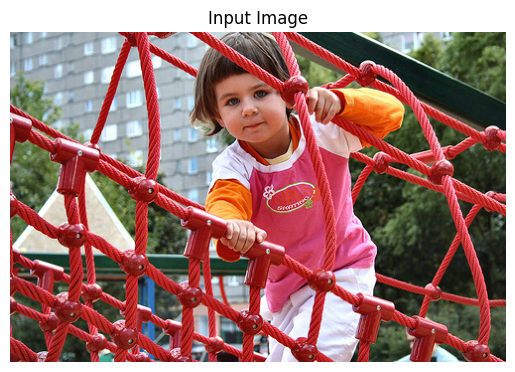

📝 Generated Caption: a child steps up on a playground toy as arms reach for him.ted rope.ted out of a playground.ted out of a playground


In [12]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import EncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor, ViTModel
from transformers.modeling_outputs import BaseModelOutput

# Load model and tokenizer
model = EncoderDecoderModel.from_pretrained("flickr8k-vit-bert-captioning")
tokenizer = AutoTokenizer.from_pretrained("flickr8k-vit-bert-captioning")
vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
vit_encoder = vit_encoder.to(device)
model.eval()
vit_encoder.eval()

# Load and preprocess image
image_path = "/kaggle/input/flickr8k/Images/1007320043_627395c3d8.jpg"
image = Image.open(image_path).convert("RGB")

# Display image
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess for ViT
inputs = processor(images=image, return_tensors="pt").to(device)

# Encode using ViT
with torch.no_grad():
    encoder = vit_encoder(**inputs)
    encoder_outputs = BaseModelOutput(last_hidden_state=encoder.last_hidden_state)

# Generate caption
generate_kwargs = {
    "max_length": 32,
    "num_beams": 4,
    "decoder_start_token_id": tokenizer.cls_token_id,
    "pad_token_id": tokenizer.pad_token_id
}

with torch.no_grad():
    generated_ids = model.generate(encoder_outputs=encoder_outputs, **generate_kwargs)

# Decode and print caption
caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("📝 Generated Caption:", caption)
